# S-I-R Infection Spread Model

For the models overview, please see:
 * https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model

In the following models,

* S stands for: Number of people at risk to catch the disease
* I means:  Having the disease
* and R is for Removed, i.e. imune to disease, e.g. from the beginning or after the cure
* D - number of days beging infectious
* $R_0$ - basic reproduction number

$N=S+I+R$

$\frac{dS}{dt}=-\beta \frac{I}{N} S $

$\frac{dI}{dt}=\beta \frac{I}{N} S-\gamma I$

$\frac{dR}{dt}=\gamma I$

$\gamma = \frac{1}{D}$

$R_0 = \frac{\beta}{\gamma}$

In [161]:
import numpy as np
import pandas as pd

def model_SIR_with_vaccination(
    Rmin = 1.2,
    Rmax = 1.75,
    population = 10000000, 
    days_to_project=500, 
    V_percentage = 17.5,
    vaccination_start=0.25,
    vaccination_end=0.5):
    
    N = population
    I = 3
    R = 0
    V = 0
    S = N - I - R - V


    gamma = 1/7

    Infected = []
    Suspectible = []
    Removed = []
    Vaccinated = []

    R_samples = np.random.uniform(Rmin, Rmax, days_to_project)
    V_people = N * V_percentage/100.0
   

    vac_start_day=int(vaccination_start*days_to_project)
    vac_remaining_days=int((1-vaccination_end)*days_to_project)
    vac_period = days_to_project - vac_start_day - vac_remaining_days

    V_people_a_day = V_people/vac_period

    Vaccination_samples = np.concatenate((
         np.zeros(vac_start_day),
         np.random.uniform(0.5*V_people_a_day, 1.5*V_people_a_day, vac_period),
         np.zeros(vac_remaining_days),
     ))
    for day in range(days_to_project):
        Rt = R_samples[day]
        beta = Rt  * gamma
    
        intI = int(I)
        intS = int(S)
        intR = int(R)
        intV = int(V)

        Infected.append(intI)
        Suspectible.append(intS)
        Removed.append(intR)
        Vaccinated.append(intV)
    
        dV = Vaccination_samples[day]
        dS = -beta * I * S/N - dV
        dI = beta*I*S/N - gamma*I
        dR = gamma*I

        S += dS
        I += dI
        R += dR
        V += dV

    df = pd.DataFrame(data={'Infected': Infected, 'Suspectible':Suspectible, 'Removed': Removed, 'Rt': R_samples, 'Vaccinated':Vaccinated})
    df['Total'] = df['Infected'] + df['Suspectible'] + df['Removed'] + df['Vaccinated']
    
    return df

#df = model_SIR_with_vaccination()
#df.tail(5)


In [162]:

import matplotlib.pyplot as plt
import seaborn as sns

def cplot(fig, ax, df, column_str, title, bars=False, color=None):
    #fig, ax = plt.subplots(figsize=(12, 12))
    clms = []
    if not isinstance(column_str, list):
        clms = [column_str]
    else:
        clms = column_str
        
    if bars:
        for c in clms:
            ax.bar(
                df.index.values,
                df[c],
                color=color
            )
    else:
        for c in clms:
            ax.plot(df.index.values,
               df[c],
               marker='o',
               color=color)

# Set title and labels for axes
    ax.legend(clms)
    ax.set(xlabel="Datum",
       ylabel=column_str,
       title=title)
    #plt.show()


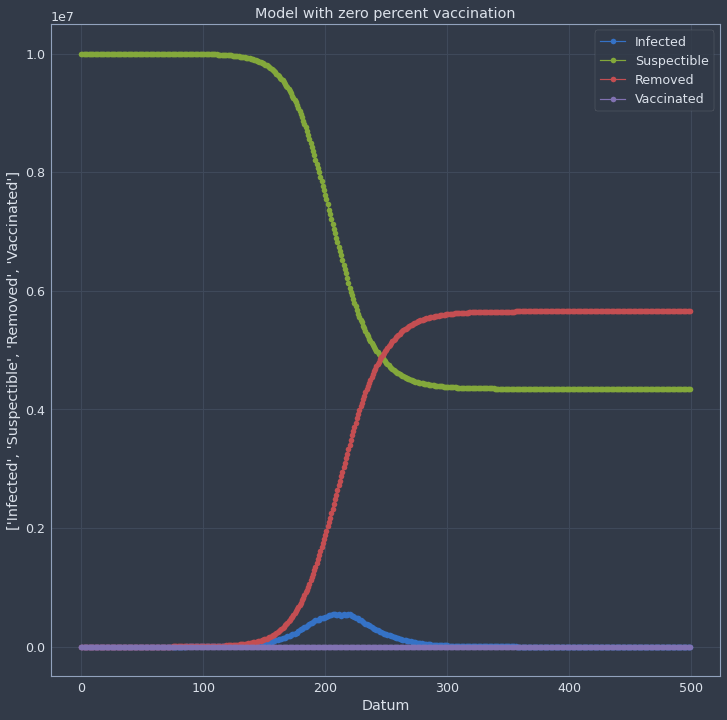

In [164]:
fig, ax = plt.subplots(figsize=(12, 12))
cplot(
    fig, ax, 
    model_SIR_with_vaccination(V_percentage=0),
    ['Infected', 'Suspectible', 'Removed', 'Vaccinated'],
    "Model with zero percent vaccination", bars=False)
plt.show()

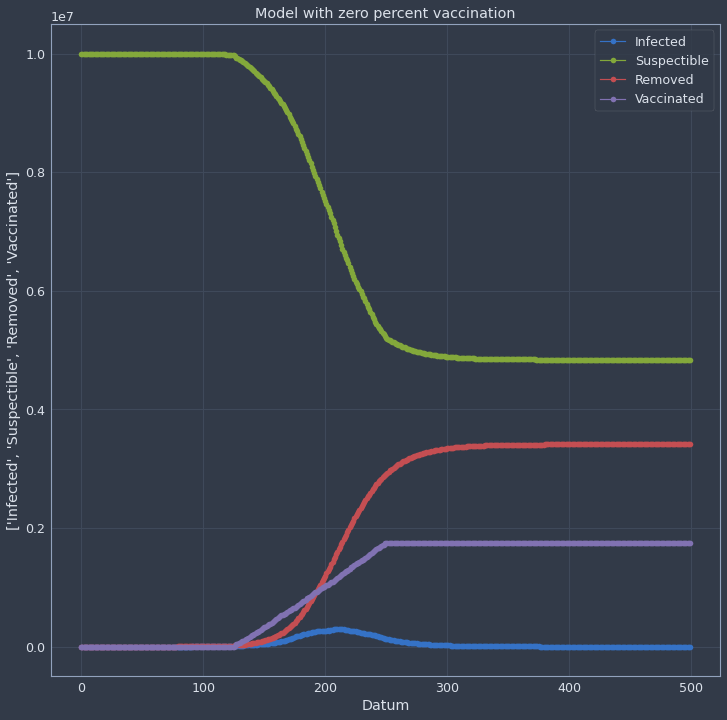

In [165]:
fig, ax = plt.subplots(figsize=(12, 12))
cplot(
    fig, ax, 
    model_SIR_with_vaccination(V_percentage=17.5),
    ['Infected', 'Suspectible', 'Removed', 'Vaccinated'],
    "Model with zero percent vaccination", bars=False)
plt.show()

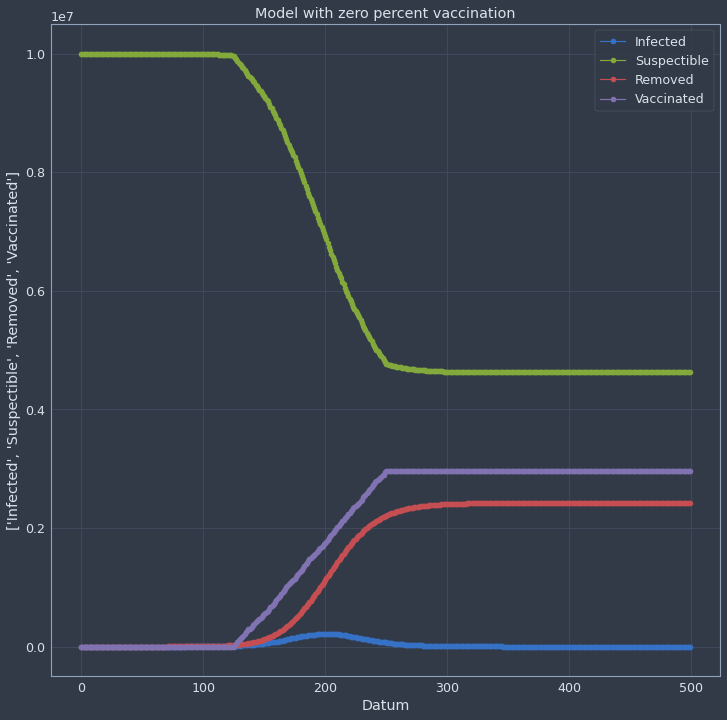

In [166]:
fig, ax = plt.subplots(figsize=(12, 12))
cplot(
    fig, ax, 
    model_SIR_with_vaccination(V_percentage=30.0),
    ['Infected', 'Suspectible', 'Removed', 'Vaccinated'],
    "Model with zero percent vaccination", bars=False)
plt.show()

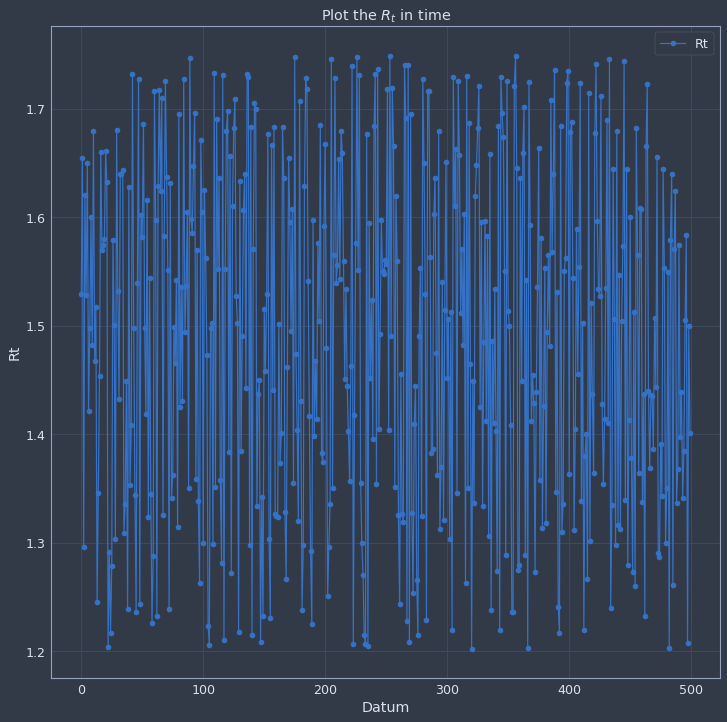

In [167]:
fig, ax = plt.subplots(figsize=(12, 12))
cplot(fig, ax, df, 'Rt', "Plot the $R_t$ in time", bars=False)
plt.show()

In [174]:
infection_CZ = pd.read_csv(
    'https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/kraj-okres-nakazeni-vyleceni-umrti.csv',
   parse_dates=['datum'], index_col=['datum']
    )
infection_PRG = infection_CZ.loc[infection_CZ['kraj_nuts_kod'] == 'CZ010']
infection_PRG['Infected'] = infection_PRG['kumulativni_pocet_nakazenych']-infection_PRG['kumulativni_pocet_vylecenych'] - infection_PRG['kumulativni_pocet_umrti']
infection_PRG.tail()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,kraj_nuts_kod,okres_lau_kod,kumulativni_pocet_nakazenych,kumulativni_pocet_vylecenych,kumulativni_pocet_umrti,Infected
datum,,,,,,
2020-10-13,CZ010,CZ0100,23549,13983,225,9341
2020-10-14,CZ010,CZ0100,24788,14156,229,10403
2020-10-15,CZ010,CZ0100,25887,14450,233,11204
2020-10-16,CZ010,CZ0100,27198,15002,244,11952
2020-10-17,CZ010,CZ0100,28349,15291,254,12804


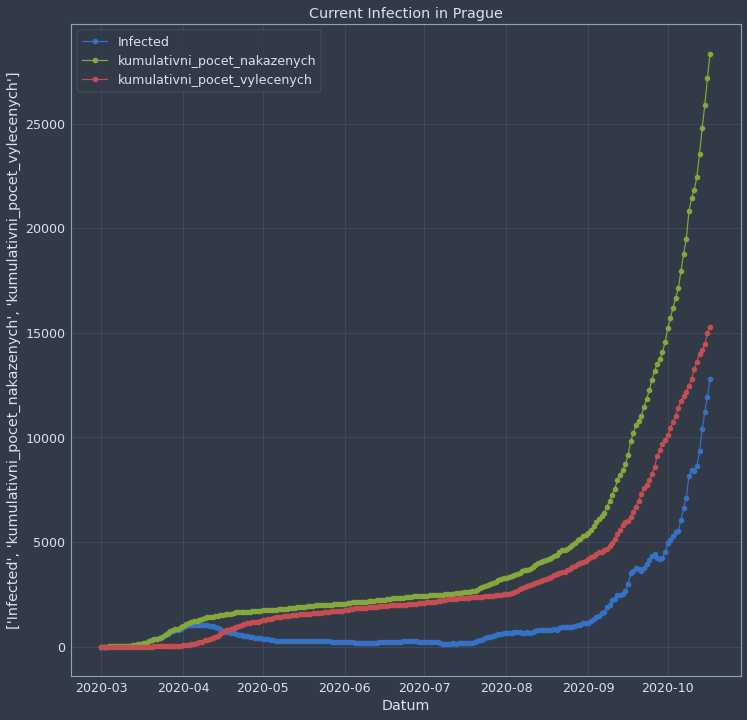

In [175]:
fig, ax = plt.subplots(figsize=(12, 12))
cplot(fig, ax, infection_PRG, ['Infected', 'kumulativni_pocet_nakazenych', 'kumulativni_pocet_vylecenych'], "Current Infection in Prague", bars=False)
plt.show()